## Data Preparation

In [50]:
!mkdir result1
!ls
!ls result1

mkdir: `result1' 디렉토리를 만들 수 없습니다: 파일이 있습니다
'Fashion MNIST with CNN.ipynb'	 result1   results   resultss


In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy # Add Deepcopy for args
import torch
from torchvision import datasets, transforms

In [34]:
# Define a transform to nomalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

#Split trainset to trainset and validationset
trainset, valset = torch.utils.data.random_split(trainset,[50000,10000])

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
partition={'train':trainset, 'val':valset, 'test':testset}

## Dataset Checking

torch.Size([1, 28, 28]) 9
torch.Size([28, 28, 1])


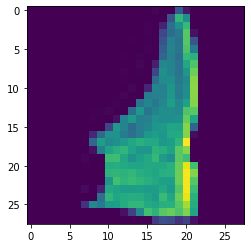

In [35]:
for i,j in testset:
    print(i.shape,j)
    i=i.transpose(0,2)
    print(i.shape)
    i=np.array(i)
    plt.imshow(i)
    break

image indices: [ 2732 43567 42613 45891 21243 30403 32103 41993]
torch.Size([3, 59, 117])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


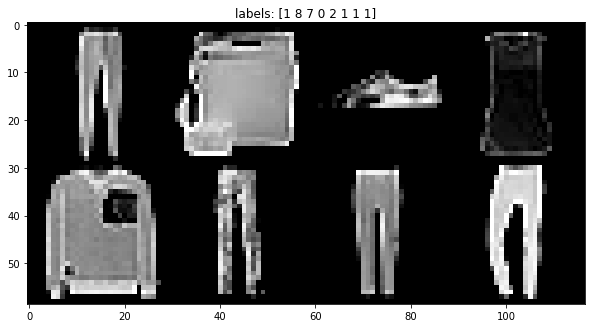

In [36]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)

# define helper function
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))

    plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(np.array(y)))

# pick random samples
grid_size = 8
rnd_inds = np.random.randint(0, len(trainset), grid_size)
print('image indices:', rnd_inds)

# create a grid from the sample images
x_grid = [trainset[i][0] for i in rnd_inds]
y_grid = [trainset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10.0, 10.0))
show(x_grid, y_grid)

## Model Architecture

In [37]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        
        self.conv1=nn.Conv2d(1,32,5,1,2)
        self.conv2=nn.Conv2d(32,64,5,1,2)
        self.conv3=nn.Conv2d(64,128,5,1,2)
        self.fc1=nn.Linear(6272,1000)
        self.fc2=nn.Linear(1000,10)
        
        self.maxpool=nn.MaxPool2d(2,2)
        self.act=nn.ReLU()
        self.dropout=nn.Dropout(0.4)
        
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.act(x)
        x=self.conv2(x)
        x=self.act(x)
        x=self.maxpool(x)
        x=self.conv3(x)
        x=self.act(x)
        x=self.maxpool(x)
        x=x.view(x.size(0),-1)
        x=self.dropout(x)
        x=self.fc1(x)
        x=self.fc2(x)
        
        return x

##  dimension_check

In [38]:
def dimension_check():
    net=CNN()
    x=torch.randn(1,1,28,28)
    y=net(x)
    print(y.shape)

In [39]:
dimension_check()

torch.Size([1, 10])


## Train, Validation, Test and Experiment

In [40]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() 

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [41]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [42]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [43]:
def experiment(partition, args):
  
    net = CNN()
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [51]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size'] ## epoch, batch_size는 실험에 영향을 미치지 않는 변수이기 때문에 삭제

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './result1/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) ## result라는 dic에 setting도 합치기 위함
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [52]:
!mkdir resultss
!ls
!ls resultss

mkdir: `resultss' 디렉토리를 만들 수 없습니다: 파일이 있습니다
'Fashion MNIST with CNN.ipynb'	 result1   results   resultss


In [55]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1/4_lr_l2"

# ====== Model Capacity ====== #

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 128
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'lr'
list_var1 = [0.00001, 0.00005]
list_var2 = [0.0015, 0.001]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) ## args.name_var1 = var1 과 같은 말
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))


Namespace(epoch=10, exp_name='exp1/4_lr_l2', l2=1e-05, lr=0.0015, optim='Adam', test_batch_size=1024, train_batch_size=128)
Epoch 0, Acc(train/val): 82.37/88.89, Loss(train/val) 0.49/0.31. Took 5.75 sec
Epoch 1, Acc(train/val): 88.71/89.49, Loss(train/val) 0.31/0.28. Took 5.74 sec
Epoch 2, Acc(train/val): 89.83/91.03, Loss(train/val) 0.28/0.24. Took 5.78 sec
Epoch 3, Acc(train/val): 90.81/91.34, Loss(train/val) 0.26/0.24. Took 5.79 sec
Epoch 4, Acc(train/val): 91.34/91.73, Loss(train/val) 0.24/0.23. Took 5.81 sec
Epoch 5, Acc(train/val): 91.87/91.61, Loss(train/val) 0.22/0.23. Took 5.81 sec
Epoch 6, Acc(train/val): 92.11/91.83, Loss(train/val) 0.22/0.22. Took 5.84 sec
Epoch 7, Acc(train/val): 92.79/92.62, Loss(train/val) 0.20/0.21. Took 5.83 sec
Epoch 8, Acc(train/val): 93.15/91.60, Loss(train/val) 0.19/0.25. Took 5.85 sec
Epoch 9, Acc(train/val): 93.19/91.79, Loss(train/val) 0.18/0.23. Took 5.89 sec
Namespace(epoch=10, exp_name='exp1/4_lr_l2', l2=1e-05, lr=0.001, optim='Adam', test_ba